# Tyson 2 State Oscillator
***
Here, as a test case, we run a simple two-state oscillator (Novak & Tyson 2008) as an example of a stochastic reaction system.
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../../..')))

MatPlotLib is used for creating custom visualizations

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
import gillespy2

***
## Build the Tyson Oscillator Model
***
Parameter values  for this biochemical system are given in concentration units. However, stochastic systems must use population values. For example, a concentration unit of $0.5mol/(L*s)$ is multiplied by a volume unit, to get a population/s rate constant. Thus, for our non-mass action reactions, we include the parameter `vol` in order to convert population units to concentration units. Volume here = 300.

In [4]:
def build_tyson_oscillator(parameter_values=None):
    # Initialize Model
    model = gillespy2.Model(name="tyson-2-state")
    
    # Set System Volume
    model.volume = 300
    
    # Define Variables (GillesPy2.Species)
    # Initial values of each species (concentration converted to pop.)
    X = gillespy2.Species(name='X', initial_value=int(0.65609071 * model.volume))
    Y = gillespy2.Species(name='Y', initial_value=int(0.85088331 * model.volume))
    
    # Add Variables to Model
    model.add_species([X, Y])

    # Define Parameters
    P   = gillespy2.Parameter(name='P', expression=2.0)
    kt  = gillespy2.Parameter(name='kt', expression=20.0)
    kd  = gillespy2.Parameter(name='kd', expression=1.0)
    a0  = gillespy2.Parameter(name='a0', expression=0.005)
    a1  = gillespy2.Parameter(name='a1', expression=0.05)
    a2  = gillespy2.Parameter(name='a2', expression=0.1)
    kdx = gillespy2.Parameter(name='kdx', expression=1.0)
    
    # Add Parameters to Model
    model.add_parameter([P, kt, kd, a0, a1, a2, kdx])

    # Define Reactions
    # creation of X:
    rxn1 = gillespy2.Reaction(
        name='X production', reactants={}, products={'X': 1},
        propensity_function='vol*1/(1+(Y*Y/((vol*vol))))'
    )
    # degradadation of X:
    rxn2 = gillespy2.Reaction(name='X degradation', reactants={'X': 1}, products={}, rate='kdx')
    # creation of Y:
    rxn3 = gillespy2.Reaction(name='Y production', reactants={'X': 1}, products={'X': 1, 'Y': 1}, rate='kt')
    # degradation of Y:
    rxn4 = gillespy2.Reaction(name='Y degradation', reactants={'Y': 1}, products={}, rate='kd')
    # nonlinear Y term:
    rxn5 = gillespy2.Reaction(
        name='Y nonlin', reactants={'Y': 1}, products={},
        propensity_function='Y/(a0 + a1*(Y/vol)+a2*Y*Y/(vol*vol))'
    )

    # Add Reactions to Model
    model.add_reaction([rxn1, rxn2, rxn3, rxn4, rxn5])

    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=20, num_points=21)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Instantiate the Model

In [5]:
tyson_model = build_tyson_oscillator()

***
## Run the Simulations
***

In [6]:
%time results = tyson_model.run()

CPU times: user 13.7 ms, sys: 10.2 ms, total: 23.8 ms
Wall time: 1.77 s


***
## Visualizations
***

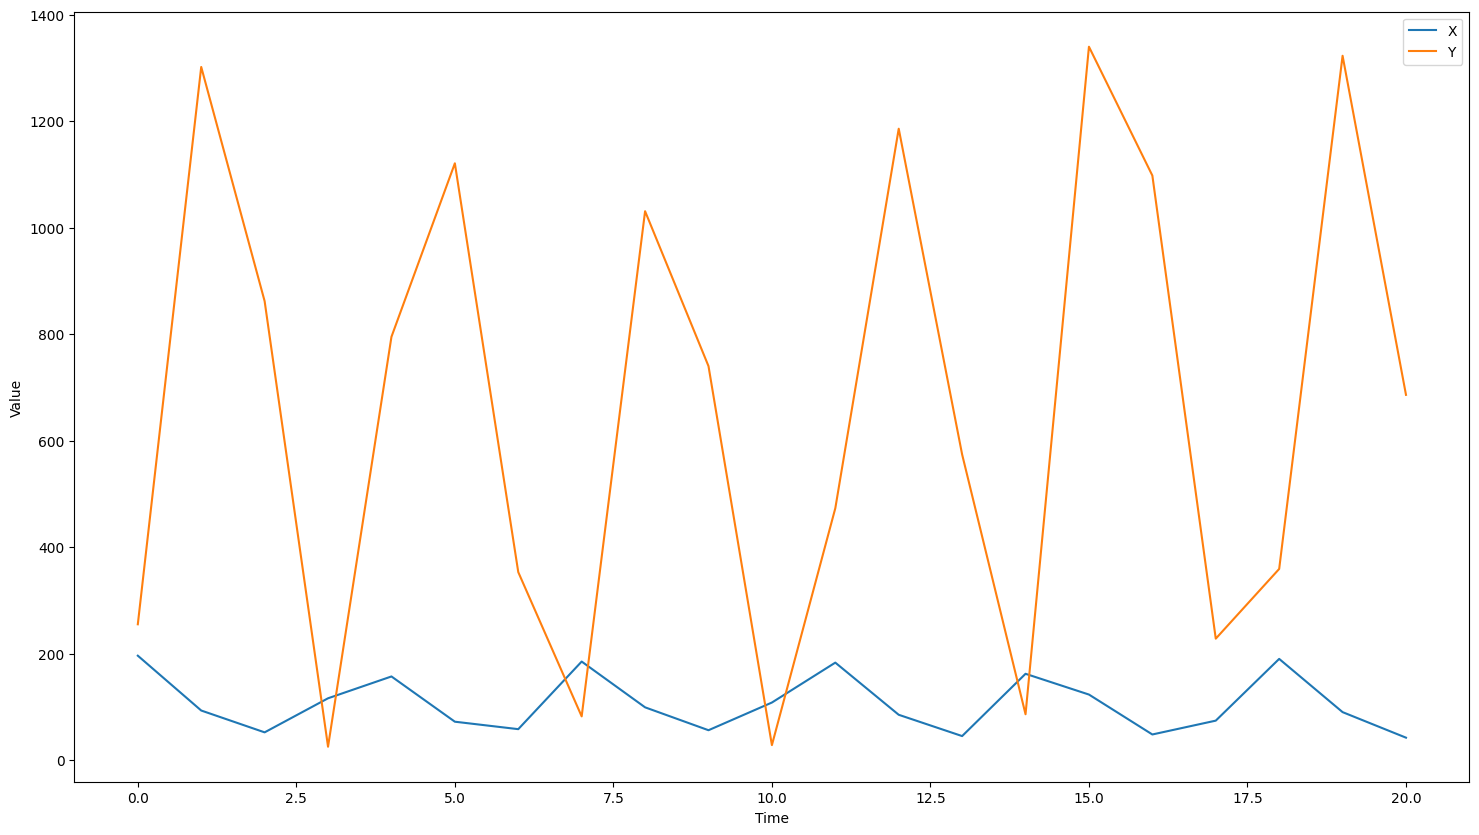

In [7]:
results.plot()

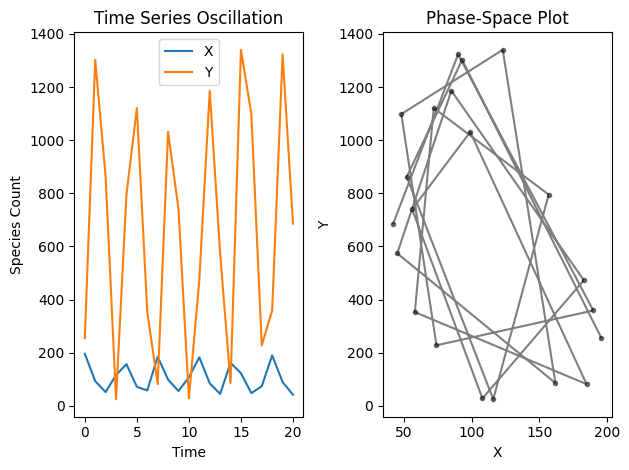

In [8]:
trajectories = results[0]
gs = gridspec.GridSpec(1,2)

ax0 = plt.subplot(gs[0,0])
ax0.plot(trajectories['time'], trajectories['X'], label='X')
ax0.plot(trajectories['time'], trajectories['Y'], label='Y')
ax0.legend()
ax0.set_xlabel('Time')
ax0.set_ylabel('Species Count')
ax0.set_title('Time Series Oscillation')

ax1 = plt.subplot(gs[0,1])
ax1.plot(trajectories['X'], trajectories['Y'], '.-k', alpha=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Phase-Space Plot')

plt.tight_layout()